In [1]:
import cooler
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from datetime import datetime

from iced import normalization

In [2]:
# data from ftp://cooler.csail.mit.edu/coolers/hg19/
name = 'Dixon2012-H1hESC-HindIII-allreps-filtered.100kb.cool'
#name = 'Rao2014-K562-MboI-allreps-filtered.500kb.cool'
c = cooler.Cooler(name)
resolution = c.binsize
mat= c.matrix(balance=True).fetch('chr2')
print(mat.shape)
idxy = ~np.all(np.isnan(mat),axis=0)
M = mat[idxy,:]
Mh = M[:,idxy]

(2432, 2432)


(1781, 512, 512)
TensorSpec(shape=(512, 512), dtype=tf.float64, name=None)


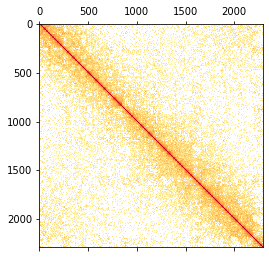

In [3]:
plt.matshow(np.log2(Mh), cmap='YlOrRd')
hic_hr = []
for i in range(len(Mh)-511):
    hic_hr.append(Mh[i:i+512, i:i+512])
hic_hr = np.array(hic_hr)
hic_hr_ds = tf.data.Dataset.from_tensor_slices(hic_hr)
print(hic_hr.shape)
print(hic_hr_ds.element_spec)

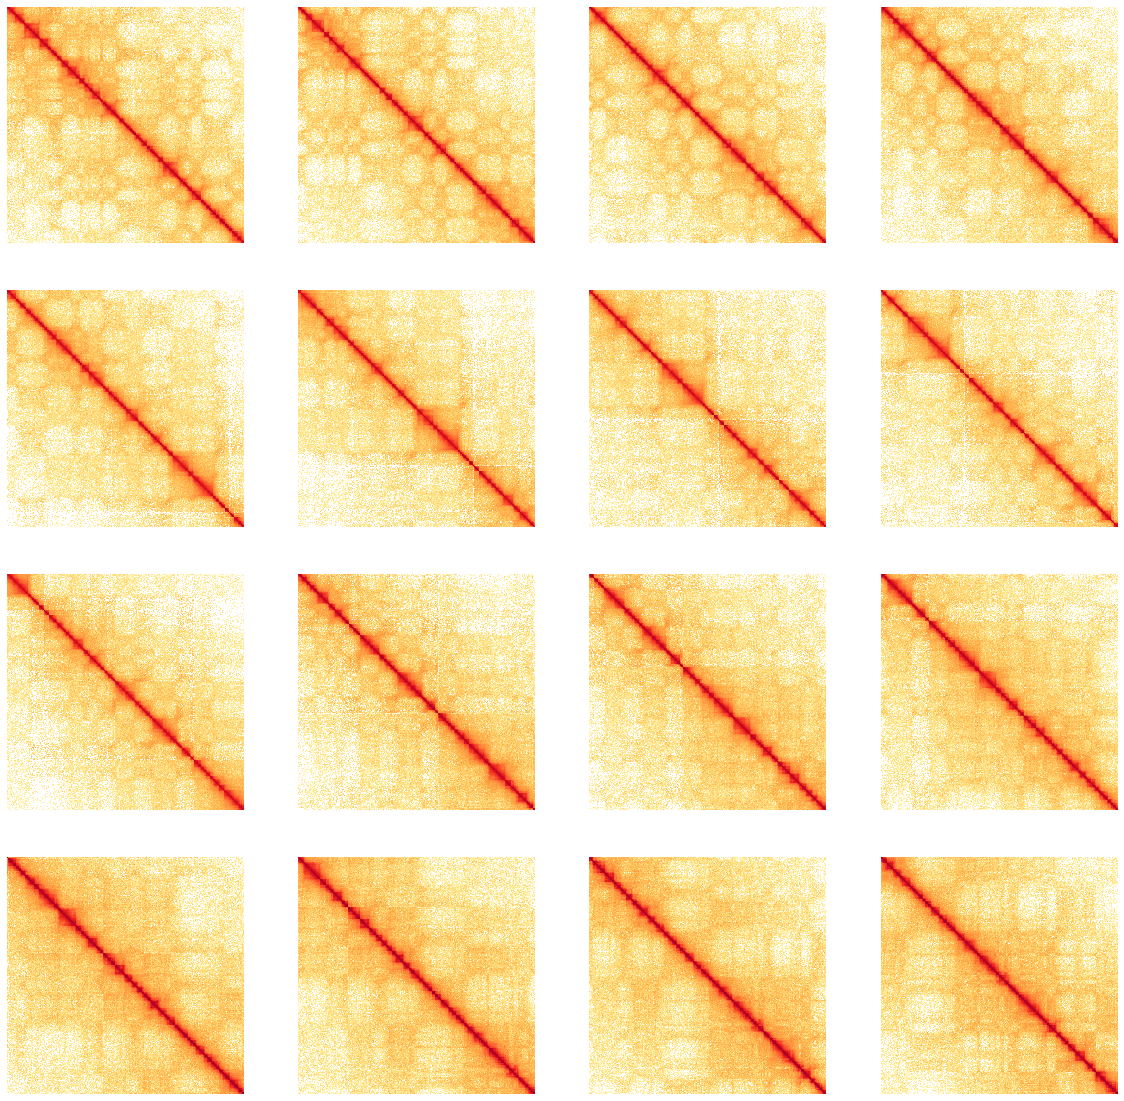

In [4]:
fig = plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.log2(hic_hr[i*100,:,:]), cmap='YlOrRd')
    plt.axis('off')

(573, 573)


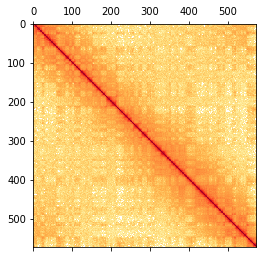

In [5]:
IMG_HEIGHT, IMG_WIDTH = int(Mh.shape[0]/4),int(Mh.shape[1]/4)
img_l = np.zeros(shape=(IMG_HEIGHT, IMG_WIDTH))
for i in list(range(0, len(Mh))):
    x = int(np.floor(i/(len(Mh)/IMG_HEIGHT)))
    for j in list(range(0,len(Mh))):
        y = int(np.floor(j/(len(Mh)/IMG_WIDTH)))
        img_l[x, y] = img_l[x, y] + Mh[i,j]
'''idxy = ~np.all(np.isnan(mat),axis=0)
Ml = matl[idxy,:]
Ml = Ml[:,idxy]'''
Ml = img_l
plt.matshow(np.log2(Ml), cmap='YlOrRd')
print(Ml.shape)

[[0.89394037 0.41145569 0.11669028 ... 0.00223855 0.00270711 0.01085779]
 [0.41142378 0.7801676  0.40574087 ... 0.00167222 0.0032995  0.0049166 ]
 [0.1166735  0.40571401 0.79842049 ... 0.00135862 0.00258682 0.00391635]
 ...
 [0.00246325 0.00184021 0.00149521 ... 0.88375441 0.29251056 0.14182557]
 [0.00297829 0.0036303  0.00284636 ... 0.29245588 0.88813674 0.34081944]
 [0.0119428  0.00540833 0.00430833 ... 0.14176763 0.34074392 0.92424752]]


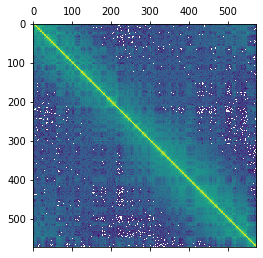

In [6]:
import copy
Ml = img_l
D = np.sqrt(Ml.sum(axis=0))**(-1)
Ml = normalization.ICE_normalization(Ml)
Ml = normalization.SCN_normalization(Ml)
print(Ml)
plt.matshow(np.log2(Ml))

In [7]:
hic_lr = []
IMG_HEIGHT, IMG_WIDTH = int(512/4),int(512/4)
print(IMG_HEIGHT, IMG_WIDTH)
for i in range(len(Ml)-IMG_HEIGHT+1):
    hic_lr.append(Ml[i:i+IMG_HEIGHT, i:i+IMG_WIDTH])
hic_lr = np.array(hic_lr)
hic_lr_ds = tf.data.Dataset.from_tensor_slices(hic_lr)
print(hic_lr.shape)
print(hic_lr_ds.element_spec)

128 128
(446, 128, 128)
TensorSpec(shape=(128, 128), dtype=tf.float64, name=None)


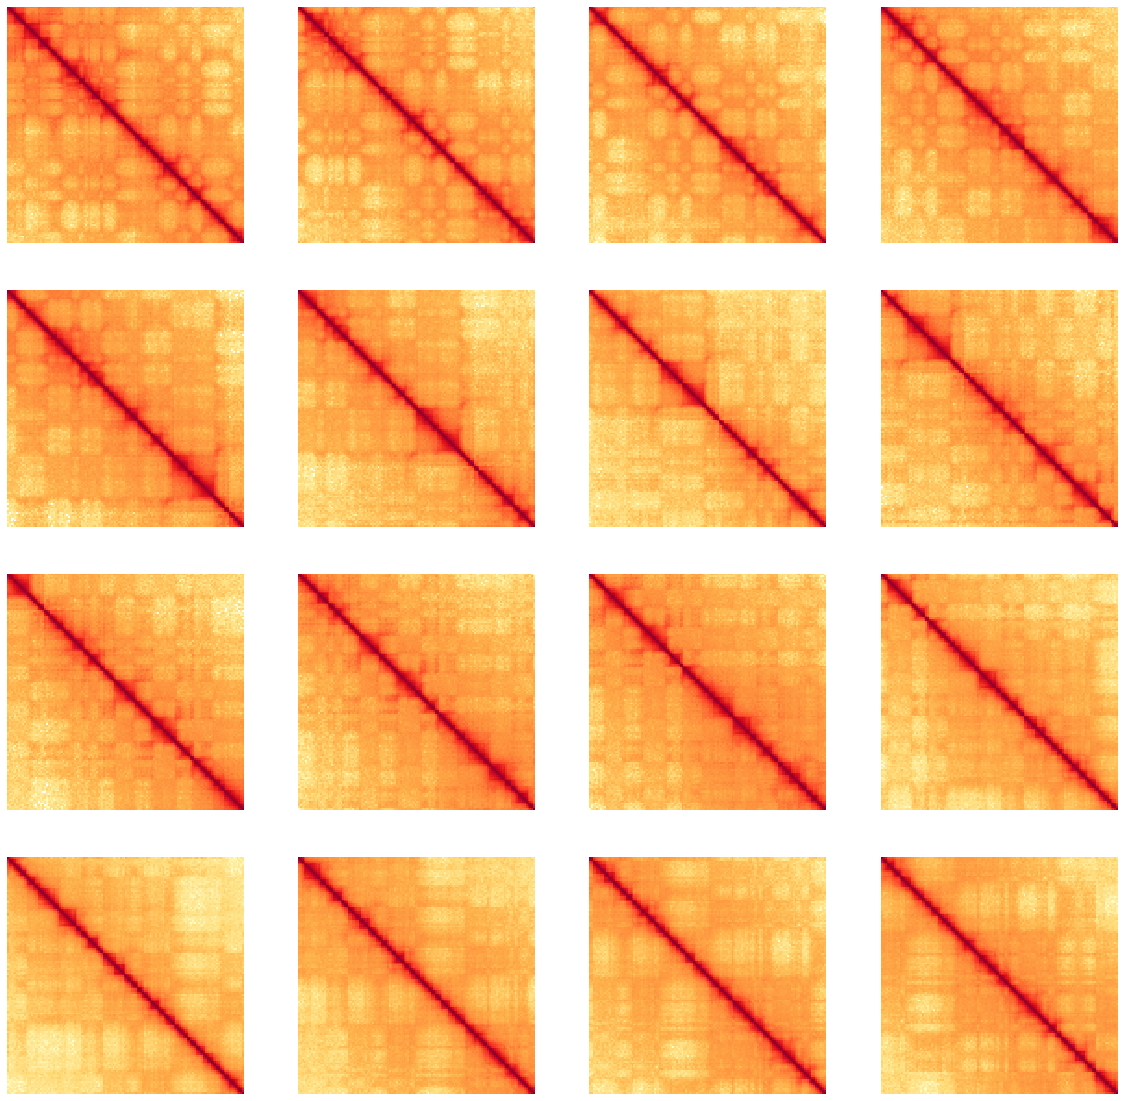

In [8]:
fig = plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.log2(hic_lr[i*25,:,:]), cmap='YlOrRd')
    plt.axis('off')

In [9]:
hic_lr = hic_lr[..., np.newaxis]
hic_hr = hic_hr[..., np.newaxis]
print(hic_lr.shape)
print(hic_hr.shape)

(446, 128, 128, 1)
(1781, 512, 512, 1)


In [10]:
class Rank1Reconstruct(tf.keras.layers.Layer):
    def __init__(self, filters, name='RR'):
        super(Rank1Reconstruct, self).__init__(name=name)
        self.num_outputs = filters
        w_init = tf.ones_initializer()
        self.w = tf.Variable(initial_value=w_init(shape=(1,1,1,filters), dtype='float32'))
        
    def build(self, input_shape):
        pass
        
    def call(self, input):
        v = tf.math.add(input, tf.constant(1e-6))
        vt = tf.transpose(v, perm=[0,2,1,3])
        rank1m = tf.multiply(tf.multiply(v, vt), self.w)
        return rank1m

class DiagonalWeight(tf.keras.layers.Layer):
    def __init__(self, input_dim, name='DW'):
        super(DiagonalWeight, self).__init__(name=name)
        #w_init = tf.random_normal_initializer()
        w_init = tf.ones_initializer()
        self.w = tf.Variable(initial_value=w_init(shape=(1, input_dim), dtype='float32'), trainable=True)

    def call(self, inputs):
        self.w.assign(tf.math.maximum(0.0, self.w))
        self.w.assign(tf.math.minimum(1.0, self.w))
        opw = tf.linalg.LinearOperatorToeplitz(self.w, self.w)

        return tf.multiply(inputs, 
            tf.expand_dims(opw.to_dense(),-1))

class Normal(tf.keras.layers.Layer):
    def __init__(self, input_dim, name='DW'):
        super(Normal, self).__init__(name=name)


    def call(self, inputs):
        rowsr = tf.math.sqrt(tf.math.reduce_sum(inputs, axis=2, keepdims=True))
        colsr = tf.math.sqrt(tf.math.reduce_sum(inputs, axis=1, keepdims=True))
        sumele = tf.math.multiply(rowsr, colsr)
        return tf.math.divide_no_nan(inputs, sumele)

'''# cross entropy -ylog(p)         
def basic_loss_function(y_true, y_pred):
    p = tf.math.divide_no_nan(tf.math.abs(tf.subtract(y_true, y_pred)), y_true)
    phat = tf.math.subtract(tf.ones_like(y_true), p)+tf.constant(1e-4)
    log = tf.math.log(phat)
    E = tf.math.scalar_mul(-1, tf.math.multiply(y_pred, log))
    return tf.math.reduce_mean(E, axis=[1,2,3])'''

def basic_loss_function(y_true, y_pred):
    return tf.add(
        tf.math.reduce_std(tf.math.divide_no_nan(tf.subtract(y_true, y_pred), y_true), axis=[1,2,3]), 
        tf.math.reduce_mean(tf.math.divide_no_nan(tf.abs(tf.subtract(y_true, y_pred)),y_true), axis=[1,2,3]))

W0328 15:47:00.335738 4509994432 deprecation.py:506] From /Users/huyangyang/anaconda3/envs/TF_base/lib/python3.7/site-packages/tensorflow_core/python/ops/linalg/linear_operator_toeplitz.py:158: calling LinearOperator.__init__ (from tensorflow.python.ops.linalg.linear_operator) with graph_parents is deprecated and will be removed in a future version.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


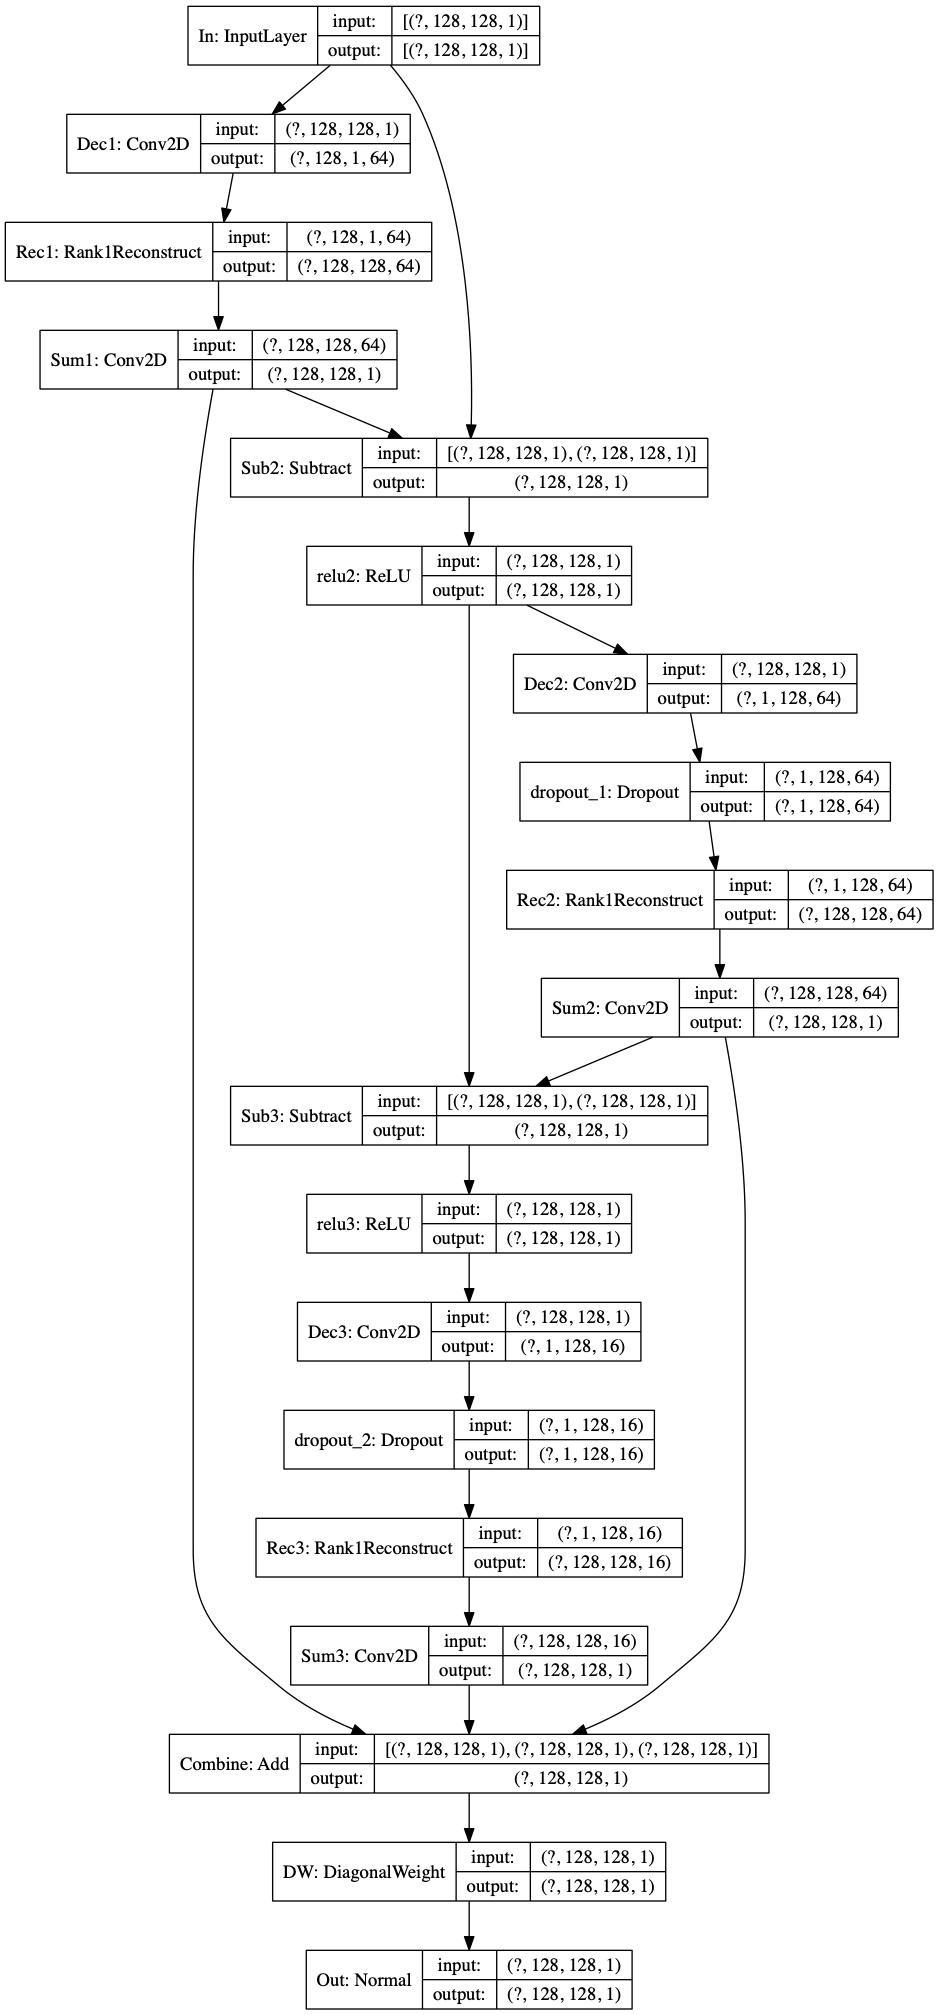

In [11]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf

In = Input(shape=(128, 128, 1), name='In')

Dec1 = tf.keras.layers.Conv2D(64, [1, 128], strides=1, padding='valid', data_format="channels_last", activation='relu', use_bias=False, kernel_constraint=tf.keras.constraints.NonNeg(),kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.01, stddev=0.1),  name='Dec1')(In) 
Drop1 = tf.keras.layers.Dropout(0.5)(Dec1)
Rec1 = Rank1Reconstruct(64, name='Rec1')(Dec1)
Sum1 = tf.keras.layers.Conv2D(1, [1,1], use_bias=False, kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1.0), kernel_constraint=tf.keras.constraints.NonNeg(), name='Sum1')(Rec1)

Residual2 = tf.keras.layers.Subtract(name='Sub2')([In, Sum1])
ReLU2 = tf.keras.layers.ReLU(name='relu2')(Residual2)

Dec2 = tf.keras.layers.Conv2D(64, [128, 1], strides=1, padding='valid', data_format="channels_last", activation='relu', use_bias=False, kernel_constraint=tf.keras.constraints.NonNeg(),kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.01, stddev=0.1),  name='Dec2')(ReLU2) 
Drop2 = tf.keras.layers.Dropout(0.5)(Dec2)
Rec2 = Rank1Reconstruct(64, name='Rec2')(Drop2)
Sum2= tf.keras.layers.Conv2D(1, [1,1], use_bias=False, kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1, seed=None), kernel_constraint=tf.keras.constraints.NonNeg(), name='Sum2')(Rec2)

Residual3 = tf.keras.layers.Subtract(name='Sub3')([ReLU2, Sum2])
ReLU3 = tf.keras.layers.ReLU(name='relu3')(Residual3)

Dec3 = tf.keras.layers.Conv2D(16, [128, 1], strides=1, padding='valid', data_format="channels_last", activation='relu', use_bias=False, kernel_constraint=tf.keras.constraints.NonNeg(),kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.01, stddev=0.1),  name='Dec3')(ReLU3) 
Drop3 = tf.keras.layers.Dropout(0.5)(Dec3)
Rec3 = Rank1Reconstruct(16, name='Rec3')(Drop3)
Sum3= tf.keras.layers.Conv2D(1, [1,1], use_bias=False, kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1, seed=None), kernel_constraint=tf.keras.constraints.NonNeg(), name='Sum3')(Rec3)

comb = tf.keras.layers.Add(name='Combine')([Sum1, Sum2, Sum3])
dw = DiagonalWeight(128, name='DW')(comb)
out = Normal(128, name='Out')(dw)

model = Model(inputs=[In],outputs=[out])
model.compile(optimizer='adam',
              loss=basic_loss_function,
              metrics=['mae'])
plot_model(model, to_file='demo.png',show_shapes=True)


In [12]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
In (InputLayer)                 [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
Dec1 (Conv2D)                   (None, 128, 1, 64)   8192        In[0][0]                         
__________________________________________________________________________________________________
Rec1 (Rank1Reconstruct)         (None, 128, 128, 64) 64          Dec1[0][0]                       
__________________________________________________________________________________________________
Sum1 (Conv2D)                   (None, 128, 128, 1)  64          Rec1[0][0]                       
______________________________________________________________________________________________

In [13]:
from datetime import datetime 
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                histogram_freq=1,
                                             write_images=True, 
                                             update_freq='batch')

In [14]:
train_data = hic_lr[::30, :,:]
print(train_data.shape)
test_data = hic_lr[1::2, :,:]


(15, 128, 128, 1)


In [15]:
import datetime
from tensorflow.keras.models import Model

class MyCustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, data):
        super(MyCustomCallback, self).__init__()
        self.data = data
        #print(data.shape)
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 8 == 0:
            intermediate_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer('Dec1').output )
            intermediate_output = intermediate_layer_model.predict(self.data)
            fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(15,15))
            axs[0,0].set_title('Dec1-H')
            axs[0,0].imshow(np.squeeze(intermediate_output))
            m = np.squeeze(self.model.get_layer('Dec1').get_weights())
            axs[1,0].set_title('Dec1-Weights')
            axs[1,0].imshow(m)

            intermediate_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer('Dec2').output )
            intermediate_output = intermediate_layer_model.predict(self.data)
            axs[0,1].set_title('Dec2-H')
            axs[0,1].imshow(np.squeeze(intermediate_output))
            m = np.squeeze(self.model.get_layer('Dec2').get_weights())
            axs[1,1].set_title('Dec2-Weights')
            axs[1,1].imshow(m)

            intermediate_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer('Dec3').output )
            intermediate_output = intermediate_layer_model.predict(self.data)
            axs[0,2].set_title('Dec3-H')
            axs[0,2].imshow(np.squeeze(intermediate_output))
            m = np.squeeze(self.model.get_layer('Dec3').get_weights())
            axs[1,2].set_title('Dec3-Weights')
            axs[1,2].imshow(m)
            plt.savefig('./lvl1/image_at_epoch_{:04d}.png'.format(epoch))
            plt.close(fig)

            fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(30,15))
            intermediate_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer('Sum1').output )
            intermediate_output = intermediate_layer_model.predict(self.data)
            axs[0,0].set_title('sum1')
            axs[0,0].imshow(np.squeeze(intermediate_output))

            intermediate_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer('Sum2').output )
            intermediate_output = intermediate_layer_model.predict(self.data)
            axs[0,1].set_title('Sum2')
            axs[0,1].imshow(np.squeeze(intermediate_output))

            intermediate_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer('Sum3').output )
            intermediate_output = intermediate_layer_model.predict(self.data)
            axs[0,2].set_title('Sum3')
            axs[0,2].imshow(np.squeeze(intermediate_output))

            intermediate_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer('relu2').output )
            intermediate_output = intermediate_layer_model.predict(self.data)
            axs[1,0].set_title('ReLU2')
            axs[1,0].imshow(np.squeeze(intermediate_output))

            intermediate_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer('relu3').output )
            intermediate_output = intermediate_layer_model.predict(self.data)
            axs[1,1].set_title('ReLU3')
            axs[1,1].imshow(np.squeeze(intermediate_output))

            intermediate_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer('Out').output )
            intermediate_output = intermediate_layer_model.predict(self.data)
            axs[1,2].set_title('Out')
            axs[1,2].imshow(np.squeeze(intermediate_output))
            plt.savefig('./lvl2/image_at_epoch_{:04d}.png'.format(epoch))
            plt.close(fig)

            intermediate_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer('DW').output)
            intermediate_output = intermediate_layer_model.predict(self.data)
            #print(intermediate_output.shape)
            fig = plt.figure(figsize=(27, 9))
            plt.subplot(1, 3, 1)
            plt.imshow(intermediate_output[0, :, :, 0], cmap='YlOrRd')
            plt.subplot(1, 3, 2)
            w = self.model.get_layer('DW').get_weights()[0]
            plt.imshow(np.squeeze(tf.linalg.LinearOperatorToeplitz(w, w).to_dense()), cmap='YlOrRd')
            plt.subplot(1, 3, 3)
            plt.imshow(np.log2(np.squeeze(intermediate_output[0, :, :, 0])))
            plt.colorbar()
            plt.savefig('./lvl3/image_at_epoch_{:04d}.png'.format(epoch))
            plt.close(fig)

            intermediate_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer('Rec1').output )
            intermediate_output = intermediate_layer_model.predict(self.data)
            #print(intermediate_output.shape)
            fig = plt.figure(figsize=(30, 30))
            for i in range(0,intermediate_output.shape[3]):
                plt.subplot(16, 16, int(i+1))
                plt.imshow(np.log2(np.squeeze(intermediate_output[0, :, :, i])), cmap='YlOrRd')
                plt.axis('off')
            
            intermediate_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer('Rec2').output )
            intermediate_output = intermediate_layer_model.predict(self.data)
            #print(intermediate_output.shape)
            for i in range(0, intermediate_output.shape[3]):
                plt.subplot(16, 16, int(33+i))
                plt.imshow(np.log2(np.squeeze(intermediate_output[0, :, :, i])), cmap='YlOrRd')
                plt.axis('off')

            intermediate_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer('Rec3').output )
            intermediate_output = intermediate_layer_model.predict(self.data)
            #print(intermediate_output.shape)
            for i in range(0, intermediate_output.shape[3]):
                plt.subplot(16, 16, int(65+i))
                plt.imshow(np.squeeze(intermediate_output[0, :, :, i]), cmap='YlOrRd')
                plt.axis('off')
            plt.savefig('./lvl4/image_at_epoch_{:04d}.png'.format(epoch))
            plt.close(fig)

(128, 128, 1)


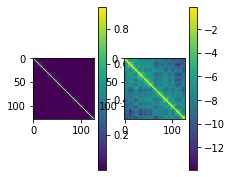

In [16]:
print(train_data[0,:,:,:].shape)
fig = plt.figure(figsize=(3, 3))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(train_data[0,:,:,:]))
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(np.log2(np.squeeze(train_data[0,:,:,:])))
plt.colorbar()

In [17]:
demo1 = np.ones(shape=[1,128,128,1])
demo1[0,:,:,:] = train_data[0,:,:,:]
fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(demo1[0,:,:,:]))
plt.subplot(1, 2, 2)
plt.imshow(np.log2(np.squeeze(demo1[0,:,:,:])))

_ = model.fit(train_data, train_data,
          epochs=800,
          batch_size=2,
          callbacks=[MyCustomCallback(demo1)])
score = model.evaluate(test_data, test_data, batch_size=16)

Train on 15 samples
Epoch 1/800
15/15 [==============================] - 7s 485ms/sample - loss: 4.9082 - mae: 0.0195
Epoch 2/800
15/15 [==============================] - 0s 23ms/sample - loss: 4.6181 - mae: 0.0195
Epoch 3/800
15/15 [==============================] - 0s 23ms/sample - loss: 4.3203 - mae: 0.0195
Epoch 4/800
15/15 [==============================] - 0s 24ms/sample - loss: 4.0941 - mae: 0.0194
Epoch 5/800
15/15 [==============================] - 0s 30ms/sample - loss: 3.8589 - mae: 0.0193
Epoch 6/800
15/15 [==============================] - 0s 27ms/sample - loss: 3.6350 - mae: 0.0193
Epoch 7/800
15/15 [==============================] - 0s 29ms/sample - loss: 3.4448 - mae: 0.0192
Epoch 8/800
15/15 [==============================] - 0s 28ms/sample - loss: 3.2464 - mae: 0.0191
Epoch 9/800
15/15 [==============================] - 7s 481ms/sample - loss: 3.0662 - mae: 0.0190
Epoch 10/800
15/15 [==============================] - 0s 28ms/sample - loss: 2.8903 - mae: 0.0189
Epoch 1

KeyboardInterrupt: 

In [ ]:
demo1[0,:,:,:] = test_data[0,:,:,:]
pre = model.predict(demo1)
fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.imshow(np.squeeze(pre[0,:,:,:]))
plt.subplot(1, 4, 2)
plt.imshow(np.log2(np.squeeze(pre[0,:,:,:])))
plt.subplot(1, 4, 3)
plt.imshow(np.log2(np.squeeze(demo1)))
plt.subplot(1, 4, 4)
plt.imshow(np.log2(np.squeeze(np.abs(pre-demo1))))
plt.colorbar()
print(np.abs(pre-demo1).sum())
print(pre.sum())
print(demo1.sum())

In [ ]:
'''def train_step(model, dataset, optimizer):
    loss_fn = tf.keras.losses.KLDivergence()
    with tf.GradientTape() as tape:
        prediction = model(dataset)
        loss = loss_fn(prediction, dataset)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss'''

In [ ]:
'''def train(dataset, EPOCHS):
    for epoch in range(EPOCHS):
        avg_loss = tf.keras.metrics.Mean(name='loss', dtype=tf.float32)
        optimizer=tf.keras.optimizers.Adam()
        start = time.time()
        for i, image_batch in enumerate(dataset):
            loss = train_step(model, image_batch, optimizer)
            avg_loss.update_state(loss)    
            tf.summary.scalar('loss', avg_loss.result(), step=optimizer.iterations)
            avg_loss.reset_states()
            if i>10:
                break
        print('Time for epoch {} is  {} sec'.format(epoch + 1, time.time() - start))'''

In [ ]:
'''EPOCHS = 20
num_examples = 16
BUFFER_SIZE = 600
BATCH_SIZE = 32
import time
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train(train_dataset, EPOCHS)'''

In [ ]:
import imageio
import glob
anim_file = 'mf_hy_3.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./lvl3/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import IPython
if IPython.version_info > (6,2,0,''):
    IPython.display.Image(filename=anim_file)